https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [6]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


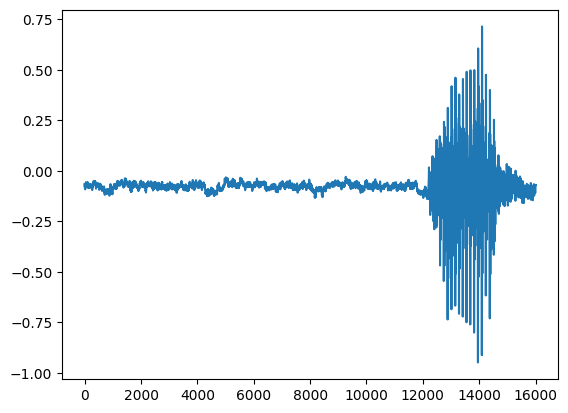

In [7]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [8]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [9]:


def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [11]:
# ZT
from torch.utils.data import DataLoader
# from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 256
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

cpu


speech to spice konverzió:

In [13]:
# kell ehhez:
# def label_to_index(word):
# def index_to_label(index):

# it = iter(train_loader)
# first = next(it)
# second = next(it)
#print(first)

# waveform_first, *_ = first[0]
# ipd.Audio(waveform_first.numpy(), rate=sample_rate)

from speech2spikes import S2S
s2s = S2S()

# Get the next batch
# batch = next(iter(train_loader))


In [20]:
batch = next(iter(train_loader))
# print(batch)
# Extract elements from the batch
train_features, train_labels = batch


In [21]:
# Ensure that train_labels is a list of tuples containing waveform and label
# If not, adjust the structure accordingly
train_labels = [(waveform, label) for waveform, label in zip(train_features, train_labels)]

# Convert the batch of audio tensors to spike trains using S2S
spike_trains, converted_labels = s2s.convert(train_labels)

In [85]:
import torch
import IPython.display as ipd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_labels_1=train_labels[1]
spike_trains_1=spike_trains[1]
converted_labels_1=converted_labels[1]

print(train_labels_1)
print("spike_trains:",spike_trains_1)
print("converted_labels:",converted_labels_1)


print(spike_trains_1.shape)
print("waveform_first:",waveform_first.shape)
print("waveform:",waveform.shape)

waveform_first, *_ = train_labels_1
ipd.Audio(waveform_first.numpy(), rate=sample_rate)







(tensor([[ 0.0147,  0.0152,  0.0157,  ..., -0.0231, -0.0205, -0.0177]]), tensor(18))
spike_trains: tensor([[[ 0.,  1.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0., -1.]]])
converted_labels: tensor(18)
torch.Size([1, 30, 161])
waveform_first: torch.Size([1, 16000])
waveform: torch.Size([1, 16000])


In [24]:
from speech2spikes import S2S as BaseS2S
import torchaudio

class CustomS2S(BaseS2S):
    def __init__(self, device=None, labels=None, n_mels=20, hop_length=80, **custom_kwargs):
        super().__init__(device=device, labels=labels)
        # Additional parameters for customization
        self._custom_kwargs = custom_kwargs

        # Update the MelSpectrogram parameters with custom values
        self._default_spec_kwargs.update({
            "n_mels": n_mels,
            "hop_length": hop_length,
            **custom_kwargs
        })
        self.transform = torchaudio.transforms.MelSpectrogram(
            **self._default_spec_kwargs
        )

Ezeket lehetett volna még változtatni (CSAK KIMÁSOLTAM):
        # Define the default spectrogram parameters
        self._default_spec_kwargs = {
            "sample_rate": 16000,
            "n_mels": 80,  # Adjust to the desired number of mel bins
            "n_fft": 512,
            "f_min": 20,
            "f_max": 4000,
            "hop_length": 80,  # Adjust to the desired hop length
        }

In [29]:
custom_s2s = CustomS2S( n_mels=30, hop_length=100)

In [87]:
batch = next(iter(train_loader))
# print(batch)
# Extract elements from the batch
train_features, train_labels = batch

# Ensure that train_labels is a list of tuples containing waveform and label
# If not, adjust the structure accordingly
train_labels = [(waveform, label) for waveform, label in zip(train_features, train_labels)]

# Convert the batch of audio tensors to spike trains using S2S
spike_trains, converted_labels = custom_s2s.convert(train_labels)

print(spike_trains[1].shape)
print(converted_labels[1])
waveform_first, *_ = train_labels[1]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)


torch.Size([1, 30, 161])
tensor(22)


In [89]:
import torch
import IPython.display as ipd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# waveform_first, *_ = train_labels[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)


cpu


torch.Size([161, 30])


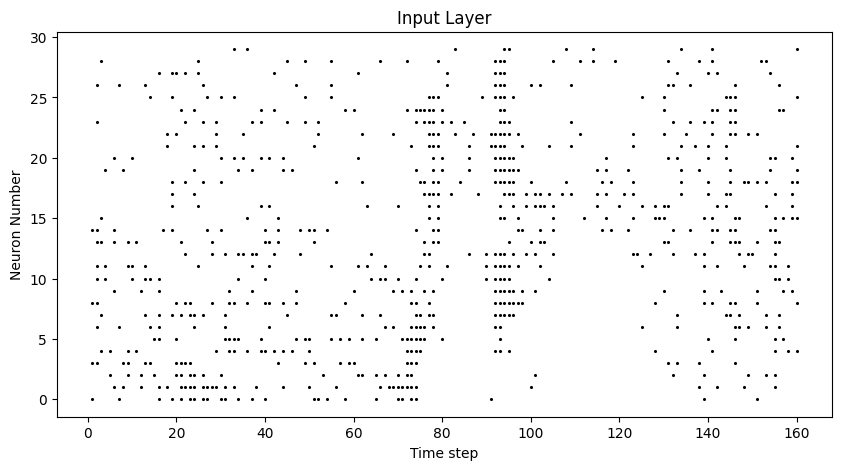

In [45]:

# https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_1_spikegen.ipynb#scrollTo=R3kY3uoOobY9
# Reshape to 2-D tesnor
sample_to_plot = spike_trains[1][-1, :,:].t()
print(sample_to_plot.shape)

# raster plot
import snntorch.spikeplot as splt
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(sample_to_plot, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()



In [66]:

# https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-p
import torchaudio.transforms as T
# Load audio if needed
print(train_features[0])
waveform, sample_rate, label, speaker_id, utterance_number = train_set[1]
# Load audio
# SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

# # Define transform
spectrogram = T.Spectrogram(n_fft=512)

# # Perform transform
spec = spectrogram(waveform)

tensor([[-6.1035e-05, -9.1553e-05, -9.1553e-05,  ..., -9.1553e-05,
         -6.1035e-05, -6.1035e-05]])


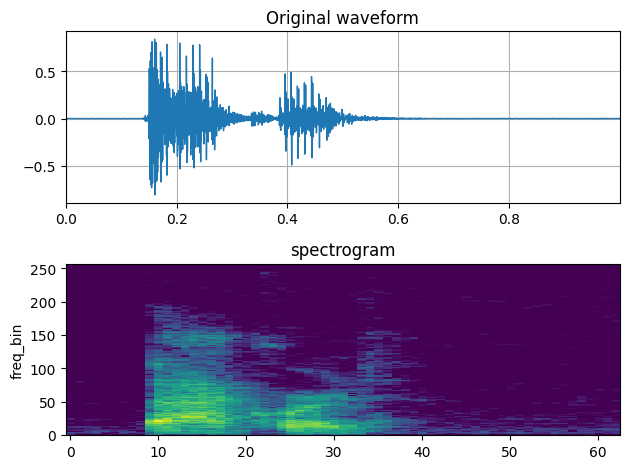

In [67]:
import librosa
from IPython.display import Audio
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")    
def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")    

fig, axs = plt.subplots(2, 1)
plot_waveform(waveform, sample_rate, title="Original waveform", ax=axs[0])
plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
fig.tight_layout()

Audio(waveform.numpy(), rate=sample_rate)



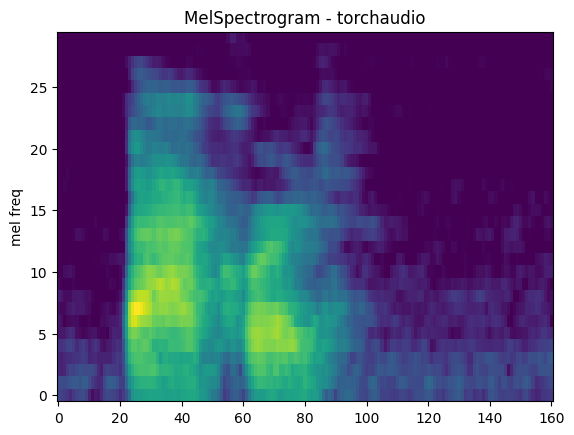

In [69]:
n_fft = 512
win_length = None
hop_length = 100
n_mels = 30

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(waveform)
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

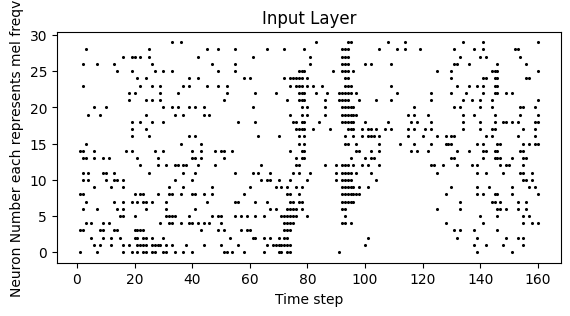

In [77]:
fig = plt.figure(facecolor="w", figsize=(6.5, 3))
ax = fig.add_subplot(111)
splt.raster(sample_to_plot, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number each represents mel freqv")
plt.show()

In [ ]:
# ZT Checking Data Structure:::
# Print the batch to understand its structure
print("Batch contents:", batch)

# Adjust the unpacking based on the structure of your batch
if len(batch) == 2:
    # For example, if your batch has only sequences and labels
    train_features, train_labels = batch
    train_sample_rates = None  # No sample rates in this case
elif len(batch) == 3:
    # If your batch has sequences, sample rates, and labels
    train_features, train_sample_rates, train_labels = batch
else:
    raise ValueError("Unexpected number of elements in the batch")

# Now, train_features, train_sample_rates, and train_labels contain the data for the batch
print("Padded Sequences shape:", train_features.shape)
print("Sample rates:", train_sample_rates)
print("Labels:", train_labels)

In [ ]:

import matplotlib.pyplot as pltlabels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels#
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [ ]:
import torch
import IPython.display as ipd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)


In [ ]:
waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)